In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

import lorenz
import generate_reservoir
import rc
import prediction_analysis

# Lorenz system

In [2]:
n_step, dt = 70000, 0.02
X, t = lorenz.solve(n_step, dt, init_cond=(1,1,1))

Text(0.5, 0, '$t$')

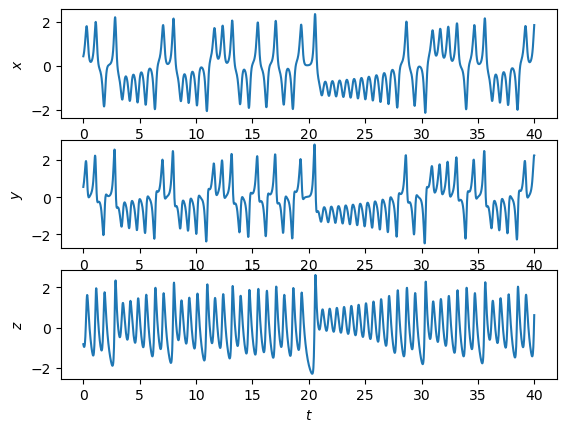

In [3]:
# Plot of x, y, z components vs. time
x, y, z = X

fig, axs = plt.subplots(3,1)
axs[0].plot(t[:2000], x[:2000])
axs[1].plot(t[:2000], y[:2000])
axs[2].plot(t[:2000], z[:2000])
axs[0].set_ylabel('$x$')
axs[1].set_ylabel('$y$')
axs[2].set_ylabel('$z$')
axs[2].set_xlabel('$t$')

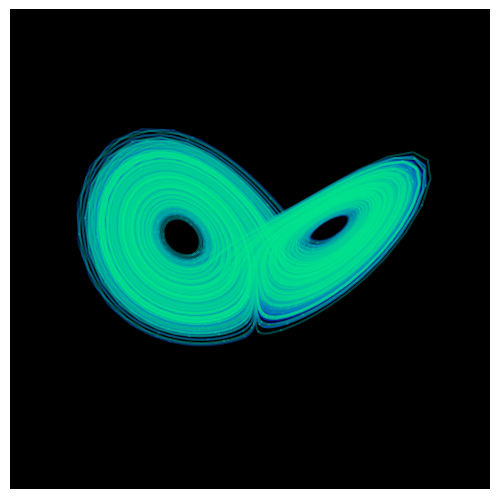

In [4]:
# 3D plot of the Lorenz attractor
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_facecolor('k')
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
s = 10
cmap = plt.cm.winter
for i in range(0,n_step-s,s):
    ax.plot(x[i:i+s+1], y[i:i+s+1], z[i:i+s+1], color=cmap(i/n_step), alpha=0.4)
ax.set_axis_off()
plt.show()

# Reservoir computer

In [5]:
def train_vanilla_RC(resparams, data):
    """TODO"""
    N = resparams['N']
    radius = resparams['radius']
    degree = resparams['degree']
    num_inputs = resparams['num_inputs']
    sigma = resparams['sigma']
    train_length = resparams['train_length']

    A = generate_reservoir.erdos_renyi_reservoir(N, degree, radius)
    W_in = generate_reservoir.generate_W_in(num_inputs, N, sigma)

    res_states = rc.reservoir_layer(A, W_in, data, resparams)

    W_out = rc.fit_output_weights(resparams, res_states, data[:, :train_length])

    return W_out, A, W_in, res_states

In [6]:
# Specify reservoir parameters
p = [0.9, 2.6667, 0.5] # spectral radius, degree, input scaling
approx_res_size = 500
resparams = {
    'num_inputs': 3,
    'radius': p[0],
    'degree': p[1],
    'nonlinear_func': np.tanh,
    'sigma': p[2],
    'train_length': 30000,
    'beta': 0.00003,
    'bias': 0.5
}
resparams['N'] = int(np.floor(approx_res_size / resparams['num_inputs'])) * resparams['num_inputs']

In [7]:
# Training
W_out, A, W_in, res_states = train_vanilla_RC(resparams, X[:, :resparams['train_length']])

In [8]:
# Prediction
prediction_steps = 1000
predictions = rc.predict(W_out, A, W_in, res_states, prediction_steps, resparams)
actual = X[:, resparams['train_length']: resparams['train_length'] + prediction_steps]

t_pred = np.linspace(0, prediction_steps * dt - dt, prediction_steps)
t_pred /= lorenz.lyapunov_time  # scale to Lyapunov times

valid_time = prediction_analysis.valid_time(predictions, actual, t_pred)

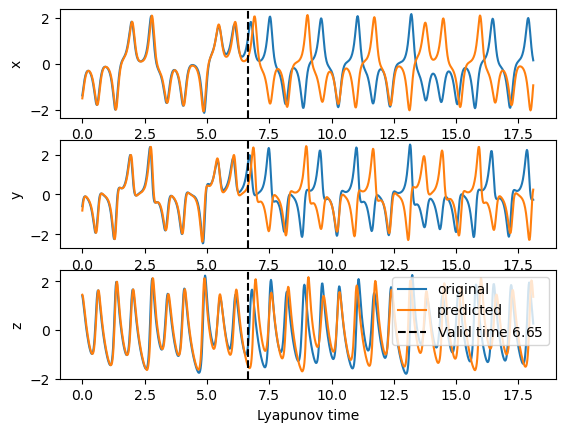

In [9]:
fig, axs = plt.subplots(3, 1)

for i in range(3):
    axs[i].plot(t_pred, X[i, resparams['train_length']: resparams['train_length'] + prediction_steps], label='original')
    axs[i].plot(t_pred, predictions[i], label='predicted')
    axs[i].set_ylabel(chr(ord('x') + i))
    axs[i].set_xlabel('Lyapunov time')
    axs[i].axvline(valid_time, ls='--', color='k', label = rf'Valid time ${valid_time:.2f}$')

plt.legend(loc='upper right')

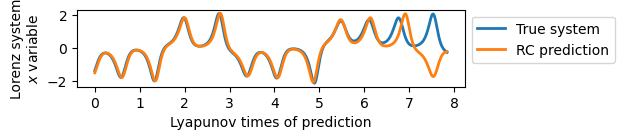

In [10]:
plt.figure(figsize=(5.0, 1.0))
length = int(t_pred.size / 2.3)
plt.plot(t_pred[:length], X[0, resparams['train_length']: resparams['train_length'] + prediction_steps][:length], label='True system', linewidth=2.)
plt.plot(t_pred[:length], predictions[0][:length], label='RC prediction', linewidth=2.)
plt.xlabel('Lyapunov times of prediction')
plt.ylabel('Lorenz system\n$x$ variable')
plt.legend(bbox_to_anchor=(1.0, 1.0))

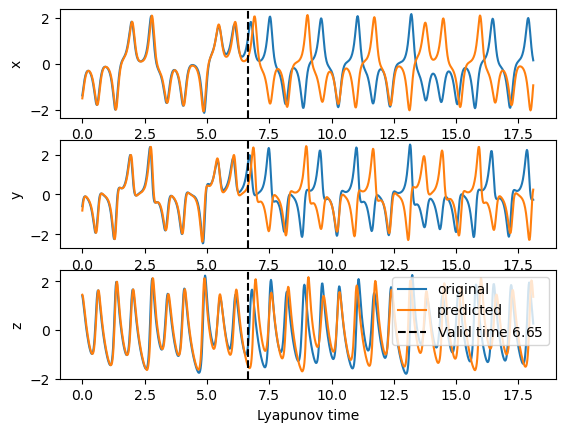

In [11]:
fig, axs = plt.subplots(3, 1)

for i in range(3):
    axs[i].plot(t_pred, X[i, resparams['train_length']: resparams['train_length'] + prediction_steps], label='original')
    axs[i].plot(t_pred, predictions[i], label='predicted')
    axs[i].set_ylabel(chr(ord('x') + i))
    axs[i].set_xlabel('Lyapunov time')
    axs[i].axvline(valid_time, ls='--', color='k', label = rf'Valid time ${valid_time:.2f}$')

plt.legend(loc='upper right')

# Hyperparameter optimization

In [10]:
def residual(p, data):
    """TODO"""

    approx_res_size = 500
    resparams = {
        'num_inputs': data.shape[0],
        'radius': p[0],
        'degree': p[1],
        'nonlinear_func': np.tanh,
        'sigma': p[2],
        'train_length': 30000,
        'beta': 0.0001,
        'bias': 0.5
    }
    resparams['N'] = int(np.floor(approx_res_size / resparams['num_inputs'])) * resparams['num_inputs']

    W_out, A, W_in, res_states = train_reservoir(resparams, data[:, :resparams['train_length']])

    output = W_out @ res_states

    # Get rid of first 10%, while reservoir is "catching up"
    output_to_use = output[:, (int(np.floor(0.1 * resparams['train_length']))):]
    data_to_use = data[:, (int(np.floor(0.1 * resparams['train_length']))): resparams['train_length']]

    diff = output_to_use - data_to_use
    sum_of_squares = np.sum(diff*diff, axis=None)
    return sum_of_squares


In [11]:
p0 = [0.8, 3, 0.4]
result = minimize(residual, p0, args=(X), method='Nelder-Mead', bounds=[(0.5, 1.5), (1, 10), (0.1, 10)], options={'maxiter':300, 'disp':True, 'xatol':0.1, 'fatol':1e-4})
# result = minimize(residual, p0, args=(X), options={'maxiter':10})

NameError: name 'train_reservoir' is not defined

In [ ]:
result

 final_simplex: (array([[0.83498695, 2.98599273, 0.42177629],
       [0.83498695, 2.98599273, 0.42177629],
       [0.83498695, 2.98599273, 0.42177629],
       [0.83498695, 2.98599273, 0.42177629]]), array([0.02106474, 0.02304256, 0.02311132, 0.02325437]))
           fun: 0.0210647399577987
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 797
           nit: 300
        status: 2
       success: False
             x: array([0.83498695, 2.98599273, 0.42177629])

# Map

In [28]:
predictions[2].shape

(1000,)

In [30]:
t_pred[-1]

18.093888

In [31]:
peaks, peak_times = prediction_analysis.find_peaks(predictions[2], t_pred)

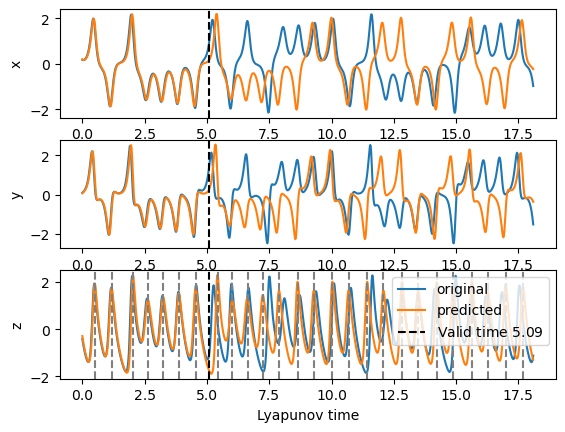

In [35]:
fig, axs = plt.subplots(3, 1)

for i in range(3):
    axs[i].plot(t_pred, X[i, resparams['train_length']: resparams['train_length'] + prediction_steps], label='original')
    axs[i].plot(t_pred, predictions[i], label='predicted')
    axs[i].set_ylabel(chr(ord('x') + i))
    axs[i].set_xlabel('Lyapunov time')
    axs[i].axvline(valid_time, ls='--', color='k', label = rf'Valid time ${valid_time:.2f}$')
        
        
for peak_time in peak_times:
    axs[2].axvline(peak_time, ls='--', color='grey')
            

plt.legend(loc='upper right')

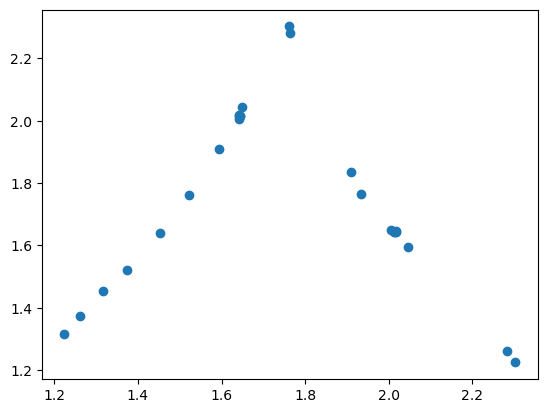

In [36]:
peaks_left = peaks[:-1]
peaks_right = peaks[1:]

plt.scatter(peaks_left, peaks_right)